#### Vit encoder 구조에 Bert encoder 구조를 참고하여 Layer Normalization 단계 추가

0. 자연어 처리 모델에서 사용하는 Transformer를 이미지 분류에 적용시킨 Vision Transformer에 관한 논문입니다.

1. 기존 Vit Transformer Encoder의 구조는 Layer Normalize 과정이 Multi-Head Attention 이전, MLP 이전에 두 번 진행된다.

    Transformer Encoder의 내부구조는 다음과 같다.

  [내부구조]. Transformer Encoder 내부에서는 먼저 Layer Normalization을 거치고, Multi-Head Attention을 지난 결과를 통과하지 않은 패치와 Skip Connection 시켜줍니다. 그리고 다시 Layer Nomalization, MLP를 거쳐 Skip Connection으로 다시 더해주는 것이 한 번 Transformer Encoder를 통과한 것입니다.
이러한 Transformer Encoder를 L번 반복합니다.

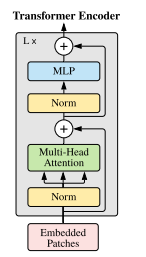

[내부구조 수식]

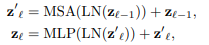

이러한 과정을 L번 반복합니다.

3. Bert의 Transformer Encoder 구조를 차용하여 성능향상을 기대한다.

 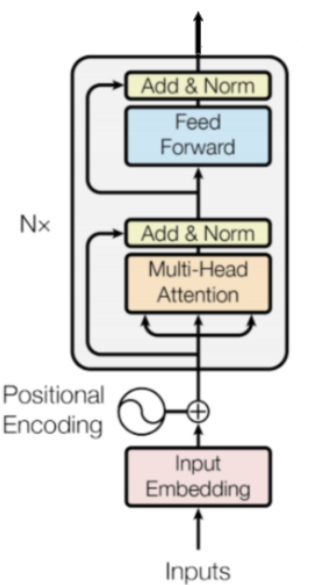

Bert의 Transformer Encoder는 output을 추가로 Linear Norm 시켜주는데 이를 기존 Transformer 에 적용한다.


4. 기존의 Transformer Encoder의 구조는 다음과 같다.


     1) Norm
     2) Multi-Head Attention
     3) Skip Connection
     4) Norm
     5) MLP
     6) Skip Connection


    x1 = layers.LayerNormalizatio(epsilon=1e-6)(encoded_patches)       
    
    attention_output = layers.MultiHeadAttention(                      
    num_heads = num_heads, key_dim = projection_dim, dropout=0.1)(x1, x1)
    
    x2 = layers.Add()([attention_output, encoded_patches])              
    
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)                   

    x3 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0.1)

    encoded_patches = layers.Add()([x3, x2])                          

5. Bert의 구조와 유사하게 MLP 이후에 Linear Normalization을 추가한 Transformer Encoder의 구조는 다음과 같다.

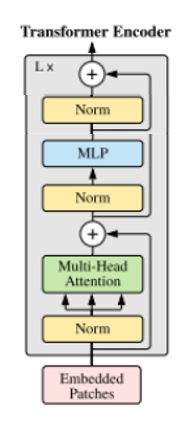

     1) Norm
     2) Multi-Head Attention
     3) Skip Connection
     4) Norm
     5) MLP
     6) Norm (Added)
     7) Skip Connection


    x1 = layers.LayerNormalizatio(epsilon=1e-6)(encoded_patches)       
    
    attention_output = layers.MultiHeadAttention(                      
    num_heads = num_heads, key_dim = projection_dim, dropout=0.1)(x1, x1)
    
    x2 = layers.Add()([attention_output, encoded_patches])              
    
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)                   

    x3 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0.1)

    x3 = layers.LayerNormalization(epsilon=1e-6)(x3)  (Added)
    
    encoded_patches = layers.Add()([x3, x2])                          

6. 결과분석

기존 Vit 학습 결과 (before)
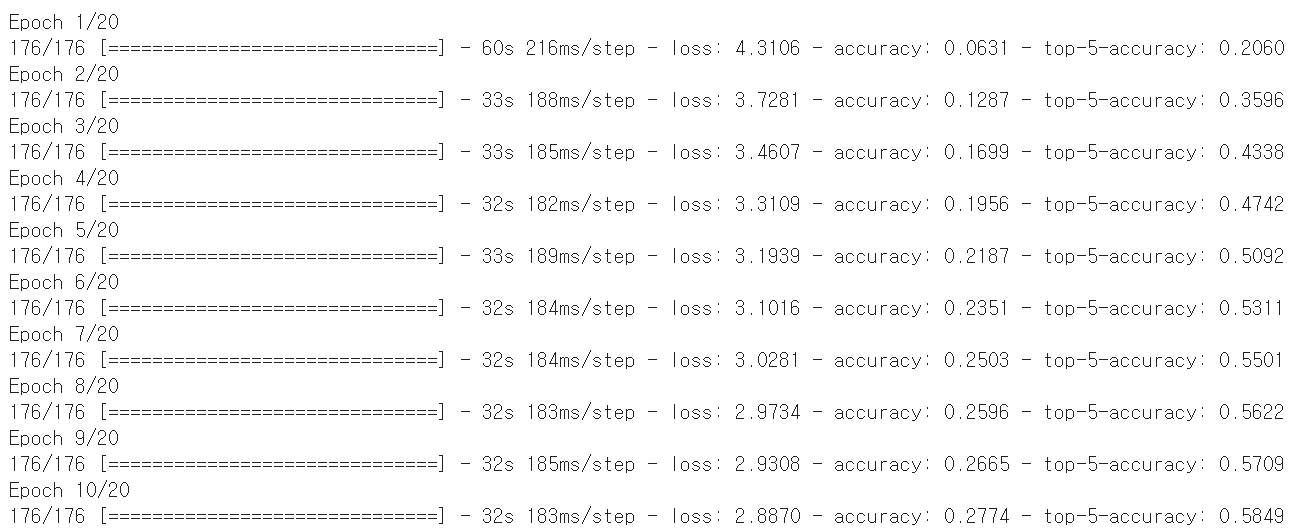

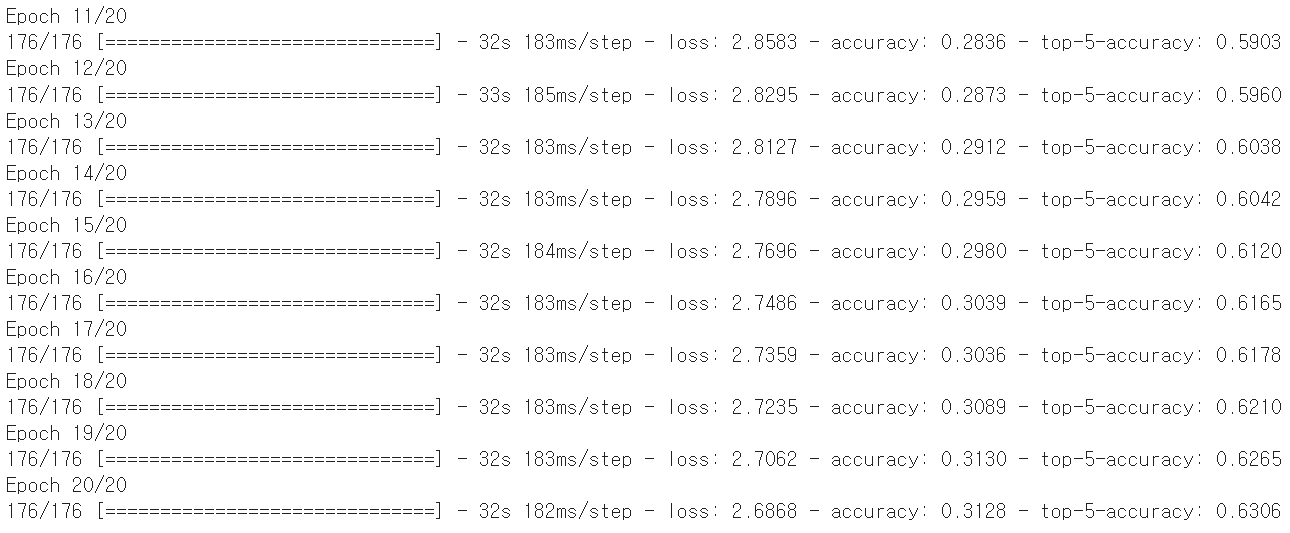


20epochs 이후 loss가 2.6868, accuracy가 0.3128 이다.


Bert의 Transformer Encoder 구조를 차용해 Linear Normalization을 추가한 Vit의  학습 결과 (after)
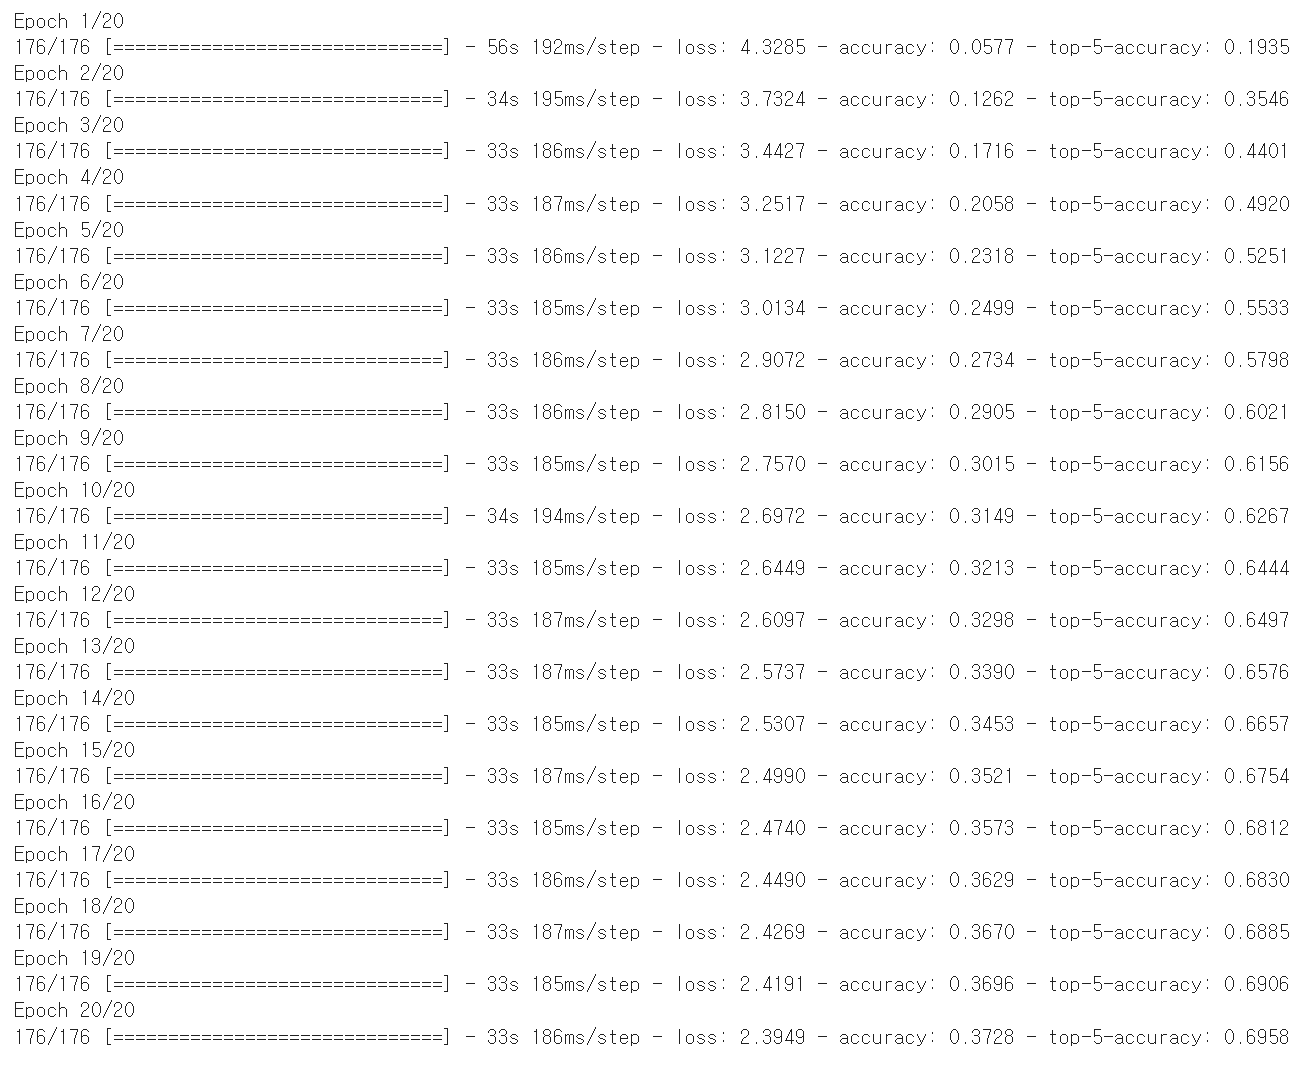

20epochs 이후 loss가 2.3949, accuracy가 0.3728 이다.

loss가 0.2919 감소, accuracy가 0.06로 소폭 증가했다.


####구현

구현할 모델에서는 Layer의 개수를 12개, D의 크기를 64, MLP의 크기를 1024, Head 개수를 4로 설정하여 진행한다.

In [1]:
# tensorflow_addons를 사용하기 위해 설치해줘야 한다.
%pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 8.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers          # vision transformer를 구성하는데 사용 (vit함수)
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
print(tf.__version__)   # tensorflow 2.14.0 버전을 사용한다.

2.14.0


데이터는 cifar100을 사용한다.
32 x 32 크기의 60000개의 이미지로 이루어져 있으며, 100개의 클래스로 분류(dolphin, fish ...) 되며 각각의 클래스는 600개의 이미지로 이루어져 있다.
또, 500개는 학습 데이터, 100개는 데이터 데이터로 이루어져 있어 총 50000개의 학습 데이터, 10000개의 테스트 데이터로 이루어져있다.

In [4]:
#  0 사용하므로 class를 100개로 지정
input_shape = (32,32,3)   # input shape는 32x32의 RGB 채널을 가진 이미지이다.

# 데이터 로드 (train과 test를 나눠서 로드한다)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape : {x_train.shape}, y_train shape : {y_train.shape}")
print(f"x_test shape : {x_test.shape}, y_test shape : {y_test.shape}")

169001437/169001437 [==============================] - 5s 0us/step
x_train shape : (50000, 32, 32, 3), y_train shape : (50000, 1)
x_test shape : (10000, 32, 32, 3), y_test shape : (10000, 1)


In [5]:
batch_size = 256

image_size = 224    # 16x16 이미지를 업사이징하여 224x224로 만들것이다.
patch_size = 32     # 패치 사이즈는 32x32,
num_patches = (image_size//patch_size)**2     # 패치의 개수는 이미지 크기를 패치사이즈로 나누고 제곱한다.

# D 차원으로 벡터화
projection_dim = 64   # D = 64
num_heads = 4

# mlp에서 사용하는 transformer unit (128, 64)
transformer_units = [
    projection_dim*2,
    projection_dim,
]

transformer_layers = 12         # layer의 개수
mlp_head_units = [2048, 1024]

In [6]:
# 이미지 업사이징, 전처리
data_augmentation = keras.Sequential(
    [
            layers.Normalization(),                         # Normalize
            layers.Resizing(image_size, image_size),        # 224 x 224
            layers.RandomFlip('horizontal'),
            layers.RandomRotation(factor=0.02),
            layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name = 'data_augmentation',
)

data_augmentation.layers[0].adapt(x_train)

In [7]:
# mlp 함수
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
      x = layers.Dense(units, activation=tf.nn.gelu)(x)   # 활성화함수로 gelu를 사용
      x = layers.Dropout(dropout_rate)(x)                 # dropout을 사용한다.
  return x

In [8]:
# 패치화하는 클래스
class Patches(layers.Layer):
  def __init__(self, patch_size):
    super().__init__()
    self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images = images,
        sizes = [1, self.patch_size, self.patch_size, 1],
        strides = [1, self.patch_size, self.patch_size, 1],
        rates = [1,1,1,1],
        padding = "VALID",    # padding 사용 X
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

In [10]:
# PatchEncoder를 class로 정의
# (Linear Projection -> Position Embedding)
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super().__init__()
    self.num_patches = num_patches

    self.projection = layers.Dense(units=projection_dim)      # D차원으로 Linear Projection
    self.position_embedding = layers.Embedding(               # position embedding
        input_dim = num_patches, output_dim = projection_dim
    )

  def call(self, patch):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)          # 0부터 patch개수만큼 1씩 증가하는 position
    encoded = self.projection(patch) + self.position_embedding(positions)   # position embedding 과정
    return encoded  # z0

In [18]:
# vision transformer
def vit():

  # 1) Patch화 ->  patch를 Linear Projection -> Position Embedding
  inputs = layers.Input(shape=input_shape)
  augmented = data_augmentation(inputs)     # inputs를 업사이징
  patches = Patches(patch_size)(augmented)  # patch 생성 (patches)
  encoded_patches = PatchEncoder(num_patches, projection_dim)(patches) # patch를 Linear Projection -> Position Embedding


  # 2) Transformer Encoder L번 반복
  for _ in range(transformer_layers):   # L번 반복

    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)       # 2) Layer Normalize

    attention_output = layers.MultiHeadAttention(                       # 1) Multi-Head Attention
        num_heads = num_heads, key_dim = projection_dim, dropout=0.1
    )(x1, x1)

    x2 = layers.Add()([attention_output, encoded_patches])              # 3) Skip Connection


    x3 = mlp(x2, hidden_units = transformer_units, dropout_rate = 0.1)  # 5) MLP

    x3 = layers.LayerNormalization(epsilon=1e-6)(x3)                    # 4) Layer Normalize (Added)


    encoded_patches = layers.Add()([x3, x2])                            # 6) Skip Connection



  # 3) MLP Head에 들어가기 전 레이어정규화
  representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation = layers.Flatten()(representation)
  representation = layers.Dropout(0.5)(representation)

  # 4) MLP Head
  features = mlp(representation, hidden_units = mlp_head_units, dropout_rate = 0.5)

  # 5) class화
  logits = layers.Dense(100)(features)

  # 6) 모델 생성
  model = keras.Model(inputs=inputs, outputs = logits)

  return model

In [19]:
model = vit()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 224, 224, 3)          7         ['input_4[0][0]']             
 ial)                                                                                             
                                                                                                  
 patches_4 (Patches)         (None, None, 3072)           0         ['data_augmentation[3][0]']   
                                                                                                  
 patch_encoder_3 (PatchEnco  (None, 49, 64)               199808    ['patches_4[0][0]']     

In [ ]:
# 학습 / 테스트
num_epochs = 20
weight_decay = 0.001
learning_rate = 0.001

optimizer = tfa.optimizers.AdamW(
    learning_rate = learning_rate, weight_decay = weight_decay
)

model.compile(
    optimizer = optimizer,
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name='top-5-accuracy'),
    ],
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size = batch_size,
    epochs = num_epochs,
    validation_split = 0.1,
)

Epoch 1/20
176/176 [==============================] - 54s 201ms/step - loss: 4.2982 - accuracy: 0.0626 - top-5-accuracy: 0.2041 - val_loss: 3.7117 - val_accuracy: 0.1338 - val_top-5-accuracy: 0.3678
Epoch 2/20
176/176 [==============================] - 34s 190ms/step - loss: 3.7132 - accuracy: 0.1300 - top-5-accuracy: 0.3628 - val_loss: 3.3710 - val_accuracy: 0.1862 - val_top-5-accuracy: 0.4588
Epoch 3/20
176/176 [==============================] - 34s 193ms/step - loss: 3.4268 - accuracy: 0.1785 - top-5-accuracy: 0.4461 - val_loss: 3.1297 - val_accuracy: 0.2334 - val_top-5-accuracy: 0.5176
Epoch 4/20
176/176 [==============================] - 33s 189ms/step - loss: 3.2283 - accuracy: 0.2115 - top-5-accuracy: 0.4982 - val_loss: 2.9759 - val_accuracy: 0.2622 - val_top-5-accuracy: 0.5550
Epoch 5/20
176/176 [==============================] - 35s 199ms/step - loss: 3.0926 - accuracy: 0.2349 - top-5-accuracy: 0.5339 - val_loss: 2.9041 - val_accuracy: 0.2692 - val_top-5-accuracy: 0.5744
Epoch

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b--', label='loss')
plt.plot(history.history['val_loss'], 'r-', label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'b--', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r-', label='val_accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()